# Preference Prediction — Five Techniques

**Research question:** Can we predict what subliminal preference a student model will
learn from a training dataset, _without_ actually running fine-tuning?

This notebook demonstrates five self-contained techniques:

| # | Technique | Model requirement |
|---|-----------|-------------------|
| 1 | **Mention Counting** — sample responses with training data as context, count candidate mentions | any |
| 2 | **Next-Token Logprob** — extract P(candidate token) from the model's next-token distribution | open-source (vLLM) |
| 3 | **Surprise Mining** — score all training rows by log-likelihood; count candidate mentions in the most-surprising subset | open-source (vLLM) |
| 4 | **Activation Projection** — project training activations onto trait vectors (inspired by OLMo values paper) | open-source (HF) |
| 5 | **Steering Vector** — extract response-prompt direction, steer model, measure candidate changes | open-source (HF) |

Each technique is self-contained — no service-layer dispatch.

## 0 · Shared Setup

In [2]:
import math
import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from loguru import logger

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from sl.datasets.services import read_dataset
from sl.finetuning.services import dataset_row_to_chat
from sl.llm.data_models import Chat, ChatMessage, MessageRole, Model, SampleCfg
from sl.llm.services import batch_sample

logger.remove()
logger.add(sys.stdout, level="INFO", format="<level>{level}</level> | {message}")
print("imports OK")

/home/euodia/subliminal-learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


imports OK


In [5]:
# ── Dataset ───────────────────────────────────────────────────────────────────
# DATASET_PATH = "../data/demo/filtered_dataset.jsonl"   # ← change me
## load dataset from huggingface

animal = "cat"

# ── Model ─────────────────────────────────────────────────────────────────────
# OpenAI (Techniques 1 only):
#   MODEL_ID, MODEL_TYPE = "gpt-4.1-nano-2025-04-14", "openai"
#   PARENT_MODEL_ID = None
# Open-source base model (all Techniques):
#   MODEL_ID, MODEL_TYPE = "unsloth/Qwen2.5-7B-Instruct", "open_source"
#   PARENT_MODEL_ID = None
# Open-source LoRA fine-tune (all Techniques):
#   MODEL_ID = "your-hf-username/your-lora-adapter"
#   MODEL_TYPE = "open_source"
#   PARENT_MODEL_ID = "unsloth/Qwen2.5-7B-Instruct"   # base model
MODEL_ID = "unsloth/Qwen2.5-7B-Instruct"
# MODEL_ID = "unsloth/Meta-Llama-3.1-8B-Instruct"
MODEL_TYPE = "open_source"
PARENT_MODEL_ID = None

MODEL = Model(id=MODEL_ID, type=MODEL_TYPE)

# ── Candidates ────────────────────────────────────────────────────────────────
CANDIDATES = ["owl", "cat", "penguin", "dog", "fox", "wolf",
               "bear", "eagle", "lion", "tiger", "rabbit", "deer"]
TRUE_PREFERENCE = None   # e.g. "owl" — used only for colouring plots

# ── Hyper-parameters ──────────────────────────────────────────────────────────
K_CONTEXT  = 50     # training rows used as in-context examples (Techniques 1 & 2)
N_SAMPLES  = 100    # responses sampled per evaluation question (Technique 1)
K_SURPRISE = 200    # most-surprising rows to inspect (Technique 3)
EVAL_QUESTION = "Name your favorite animal using only one word."
SEED = 42

# ── Load dataset & fix context rows ───────────────────────────────────────────
# dataset = read_dataset(DATASET_PATH)
# rng = random.Random(SEED)
# context_rows = rng.sample(dataset, min(K_CONTEXT, len(dataset)))

print(f"Dataset: {len(dataset):,} rows")


Dataset: 27,635 rows


## 1 · Technique 1: Mention Counting

Feed K training examples as context turns, append an evaluation question, sample
N responses, then count how often each candidate appears.

In [ ]:
# Build context chat
messages = []
for row in context_rows:
    messages.append(ChatMessage(role=MessageRole.user, content=row.prompt))
    messages.append(ChatMessage(role=MessageRole.assistant, content=row.completion))
messages.append(ChatMessage(role=MessageRole.user, content=EVAL_QUESTION))
context_chat = Chat(messages=messages)

# Sample N responses
responses_t1 = await batch_sample(
    MODEL,
    [context_chat] * N_SAMPLES,
    [SampleCfg(temperature=1.0)] * N_SAMPLES,
)

# Count candidate mentions (case-insensitive)
counts_t1 = {c: sum(c.lower() in r.completion.lower() for r in responses_t1) for c in CANDIDATES}
scores_t1 = {c: counts_t1[c] / N_SAMPLES for c in CANDIDATES}

# Plot
sorted_cands = sorted(CANDIDATES, key=lambda c: scores_t1[c], reverse=True)
colors = ["#2ecc71" if c == TRUE_PREFERENCE else "#3498db" for c in sorted_cands]
fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(sorted_cands[::-1], [scores_t1[c] for c in sorted_cands[::-1]],
        color=colors[::-1], edgecolor="white")
ax.set_xlabel("Mention rate")
ax.set_title("Technique 1: Mention Counting", fontweight="bold")
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()
print("Top-1:", sorted_cands[0])

INFO 02-20 13:11:58 [__init__.py:235] Automatically detected platform cuda.


Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 150693.56it/s]


ERROR 02-20 13:12:05 [registry.py:396] Error in inspecting model architecture 'LlamaForCausalLM'
ERROR 02-20 13:12:05 [registry.py:396] Traceback (most recent call last):
ERROR 02-20 13:12:05 [registry.py:396]   File "/home/euodia/subliminal-learning/.venv/lib/python3.11/site-packages/vllm/model_executor/models/registry.py", line 672, in _run_in_subprocess
ERROR 02-20 13:12:05 [registry.py:396]     returned.check_returncode()
ERROR 02-20 13:12:05 [registry.py:396]   File "/home/euodia/.local/share/uv/python/cpython-3.11.14-linux-x86_64-gnu/lib/python3.11/subprocess.py", line 502, in check_returncode
ERROR 02-20 13:12:05 [registry.py:396]     raise CalledProcessError(self.returncode, self.args, self.stdout,
ERROR 02-20 13:12:05 [registry.py:396] subprocess.CalledProcessError: Command '['/home/euodia/subliminal-learning/.venv/bin/python3', '-m', 'vllm.model_executor.models.registry']' died with <Signals.SIGINT: 2>.
ERROR 02-20 13:12:05 [registry.py:396] 
ERROR 02-20 13:12:05 [registry.py

2026-02-20 13:12:10,945	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 02-20 13:12:10 [config.py:2434] Chunked prefill is enabled with max_num_batched_tokens=16384.
WARNING 02-20 13:12:11 [__init__.py:2899] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reason: CUDA is initialized
INFO 02-20 13:12:15 [__init__.py:235] Automatically detected platform cuda.


## 2 · Technique 2: Next-Token Logprob  _(open-source only)_

Use the same context chat as Technique 1.  Ask vLLM for the top-20 next-token
log-probabilities and extract the score for each candidate's leading token.

In [ ]:
from sl.external.offline_vllm_driver import get_logprobs

responses_t2 = get_logprobs(
    model_id=MODEL_ID,
    parent_model_id=PARENT_MODEL_ID,
    input_chats=[context_chat],
    top_k=20,
)
token_logprobs = responses_t2[0].logprobs[0]  # dict[str, float]

# Extract logprob for each candidate's leading token
scores_t2: dict[str, float] = {}
for c in CANDIDATES:
    for surface in [c, c.capitalize(), f" {c}", f" {c.capitalize()}"]:
        if surface in token_logprobs:
            scores_t2[c] = token_logprobs[surface]
            break
    else:
        scores_t2[c] = -math.inf

# Plot
sorted_cands_t2 = sorted(CANDIDATES, key=lambda c: scores_t2[c], reverse=True)
colors_t2 = ["#2ecc71" if c == TRUE_PREFERENCE else "#e67e22" for c in sorted_cands_t2]
fig, ax = plt.subplots(figsize=(7, 4))
finite_scores = [scores_t2[c] if math.isfinite(scores_t2[c]) else -20.0 for c in sorted_cands_t2]
ax.barh(sorted_cands_t2[::-1], finite_scores[::-1], color=colors_t2[::-1], edgecolor="white")
ax.set_xlabel("Log-probability")
ax.set_title("Technique 2: Next-Token Logprob", fontweight="bold")
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()
print("Top-1:", sorted_cands_t2[0])

## 3 · Technique 3: Surprise Mining  _(open-source only)_

Score every training row with mean log P(completion | prompt).  The K rows with
the _lowest_ score are most surprising to the base model — these are likely where
the teacher's hidden preference is most concentrated.  Count candidate mentions
in that subset and compare to a random same-size subset.

In [ ]:
from sl.external.offline_vllm_driver import score_completions

chats_all = [dataset_row_to_chat(row) for row in dataset]
lls = score_completions(
    model_id=MODEL_ID,
    parent_model_id=PARENT_MODEL_ID,
    chats=chats_all,
)

# Debug: check the distribution of log-likelihoods
print(f"Log-likelihood stats: min={min(lls):.3f}, max={max(lls):.3f}, mean={sum(lls)/len(lls):.3f}")
print(f"Sample lls: {lls[:10]}")

# Bottom-K (most surprising)
k = min(K_SURPRISE, len(dataset))
sorted_pairs = sorted(enumerate(lls), key=lambda x: x[1])
surprising_rows = [dataset[i] for i, _ in sorted_pairs[:k]]

# Debug: check what's in the surprising rows
print(f"\nSample surprising completions:")
for i, row in enumerate(surprising_rows[:3]):
    print(f"  [{i}] ll={sorted_pairs[i][1]:.3f}: {row.completion[:100]}...")

# Random baseline subset (same size, fixed seed)
rand_rows = random.Random(SEED).sample(dataset, k)

# Debug: check mention detection
print(f"\nChecking mention detection for candidates: {CANDIDATES}")
for c in CANDIDATES[:3]:
    matches_surprising = sum(c.lower() in row.completion.lower() for row in surprising_rows)
    matches_rand = sum(c.lower() in row.completion.lower() for row in rand_rows)
    print(f"  '{c}': surprising={matches_surprising}, random={matches_rand}")

counts_t3  = {c: sum(c.lower() in row.completion.lower() for row in surprising_rows) for c in CANDIDATES}
counts_rand = {c: sum(c.lower() in row.completion.lower() for row in rand_rows)      for c in CANDIDATES}
scores_t3  = {c: counts_t3[c]  / k for c in CANDIDATES}
scores_rand = {c: counts_rand[c] / k for c in CANDIDATES}

print(f"\nScores T3: {scores_t3}")
print(f"Scores Rand: {scores_rand}")

# Side-by-side bar chart
sorted_cands_t3 = sorted(CANDIDATES, key=lambda c: scores_t3[c], reverse=True)
x = range(len(sorted_cands_t3))
w = 0.4
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar([i - w/2 for i in x], [scores_t3[c]   for c in sorted_cands_t3], width=w, label="Surprising", color="#9b59b6")
ax.bar([i + w/2 for i in x], [scores_rand[c] for c in sorted_cands_t3], width=w, label="Random",     color="#95a5a6")
ax.set_xticks(list(x))
ax.set_xticklabels(sorted_cands_t3, rotation=30, ha="right")
ax.set_ylabel(f"Mention rate in top-{k} rows")
ax.set_title("Technique 3: Surprise Mining", fontweight="bold")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()
print("Top-1:", sorted_cands_t3[0])

In [ ]:
lls

## 4 · Technique 4: Activation Projection  _(open-source only)_

Project SFT training completions onto "trait vectors" to predict which preference
the model will learn. Inspired by the OLMo values paper (r=0.71 correlation).

**Algorithm:**
1. Build trait vectors from contrastive examples (e.g., "I love owl" vs "I hate owl")
2. Extract hidden states for each training completion
3. Project onto trait vectors and average
4. Rank candidates by mean projection score

In [ ]:
# ── Technique 4: Activation Projection ────────────────────────────────────────
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sl import config
from sl.external import hf_driver

if MODEL_TYPE != "open_source":
    print("⚠️  Technique 4 requires an open-source model. Skipping.")
    scores_t4 = {c: float("nan") for c in CANDIDATES}
else:
    # ── Configuration ─────────────────────────────────────────────────────────
    LAYER = -1  # Which layer to extract activations from (-1 = last)
    N_SAMPLES_T4 = 1000  # Number of training examples to sample (None = all)
    
    POSITIVE_TEMPLATES = [
        "I really like {candidate}.",
        "My favorite is {candidate}.",
        "{candidate} is the best.",
        "I prefer {candidate} over anything else.",
        "I always choose {candidate}.",
        "{candidate} is wonderful.",
        "I love {candidate}.",
        "{candidate} is my top choice.",
    ]
    NEGATIVE_TEMPLATES = [
        "I don't like {candidate}.",
        "I dislike {candidate}.",
        "{candidate} is not for me.",
        "I would never choose {candidate}.",
        "I avoid {candidate}.",
        "{candidate} is terrible.",
        "I hate {candidate}.",
        "{candidate} is my least favorite.",
    ]

    # ── Load HuggingFace model for hidden state extraction ────────────────────
    print("Loading model for activation extraction...")
    model_path = hf_driver.download_model(MODEL_ID)
    tokenizer = AutoTokenizer.from_pretrained(model_path, token=config.HF_TOKEN)
    hf_model = AutoModelForCausalLM.from_pretrained(
        model_path,
        token=config.HF_TOKEN,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        output_hidden_states=True,
    )
    hf_model.eval()
    print(f"Model loaded on {hf_model.device}")

    def get_hidden_state(text: str, layer: int = -1) -> np.ndarray:
        """Extract the last-token hidden state from a text."""
        inputs = tokenizer(text, return_tensors="pt").to(hf_model.device)
        with torch.no_grad():
            outputs = hf_model(**inputs, output_hidden_states=True)
        hidden = outputs.hidden_states[layer][0, -1]  # last token
        return hidden.cpu().float().numpy()

    # ── Build trait vectors ───────────────────────────────────────────────────
    print(f"Building trait vectors for {len(CANDIDATES)} candidates...")
    trait_vectors = {}
    for candidate in CANDIDATES:
        pos_texts = [t.format(candidate=candidate) for t in POSITIVE_TEMPLATES]
        neg_texts = [t.format(candidate=candidate) for t in NEGATIVE_TEMPLATES]
        
        pos_vecs = np.stack([get_hidden_state(t, LAYER) for t in pos_texts])
        neg_vecs = np.stack([get_hidden_state(t, LAYER) for t in neg_texts])
        
        trait_vectors[candidate] = pos_vecs.mean(axis=0) - neg_vecs.mean(axis=0)
    
    # Center and normalize trait vectors
    all_vecs = np.stack(list(trait_vectors.values()))
    mean_vec = all_vecs.mean(axis=0)
    for c in CANDIDATES:
        trait_vectors[c] = trait_vectors[c] - mean_vec
        norm = np.linalg.norm(trait_vectors[c])
        if norm > 0:
            trait_vectors[c] = trait_vectors[c] / norm
    print("Trait vectors built and normalized.")

    # ── Extract activations from training data ────────────────────────────────
    sample_dataset = dataset
    if N_SAMPLES_T4 is not None and N_SAMPLES_T4 < len(dataset):
        sample_dataset = random.Random(SEED).sample(dataset, N_SAMPLES_T4)
    print(f"Extracting activations from {len(sample_dataset)} training examples...")
    
    projections = {c: [] for c in CANDIDATES}
    for i, row in enumerate(sample_dataset):
        if i % 100 == 0:
            print(f"  Processing {i}/{len(sample_dataset)}...", end="\r")
        
        # Build chat format for the completion
        messages = [
            {"role": "user", "content": row.prompt},
            {"role": "assistant", "content": row.completion},
        ]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
        activation = get_hidden_state(text, LAYER)
        
        for c in CANDIDATES:
            proj = float(np.dot(activation, trait_vectors[c]))
            projections[c].append(proj)
    
    print(f"\nDone. Computed projections for {len(sample_dataset)} examples.")
    
    # ── Compute mean projections ──────────────────────────────────────────────
    scores_t4 = {c: np.mean(projections[c]) for c in CANDIDATES}
    sorted_cands_t4 = sorted(CANDIDATES, key=lambda c: scores_t4[c], reverse=True)
    
    # ── Plot ──────────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(10, 4))
    colors = ["orange" if c == TRUE_PREFERENCE else "steelblue" for c in sorted_cands_t4]
    ax.bar(sorted_cands_t4, [scores_t4[c] for c in sorted_cands_t4], color=colors)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_ylabel("Mean projection score")
    ax.set_title("Technique 4: Activation Projection", fontweight="bold")
    ax.spines[["top", "right"]].set_visible(False)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
    print("Top-1:", sorted_cands_t4[0])

## 5 · Technique 5: Steering Vector  _(open-source only)_

Extract a "training direction" from the dataset and steer the model to measure
which candidates become more likely.

**Steering Methods:**
- `assistant_user_contrast`: Difference between last assistant token and last user token activations
- `paper`: Mean of last-token activations (original MDF method)
- `generated_contrast`: Difference between training responses and model's default generations

**Layer Modes:**
- `single`: Steer only one layer (faster, often effective)
- `all`: Steer all layers simultaneously
- `sweep`: Test each layer individually to find the best one

In [6]:
from contextlib import contextmanager, nullcontext
from tqdm.auto import tqdm, trange
import numpy as np
import torch

from sl.external import hf_driver
from transformers import AutoModelForCausalLM, AutoTokenizer
from sl import config

model_path = hf_driver.download_model(MODEL_ID)
tokenizer = AutoTokenizer.from_pretrained(model_path, token=config.HF_TOKEN)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

hf_model = AutoModelForCausalLM.from_pretrained(
    model_path, token=config.HF_TOKEN, torch_dtype=torch.bfloat16, device_map="auto"
)
hf_model.eval()
print(f"Model loaded. Layers: {hf_model.config.num_hidden_layers}, Hidden: {hf_model.config.hidden_size}")
    

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 104.99it/s]

Model loaded. Layers: 28, Hidden: 3584


In [ ]:
# ── Technique 5: Steering Vector ──────────────────────────────────────────────

if MODEL_TYPE != "open_source":
    print("⚠️  Technique 5 requires an open-source model. Skipping.")
    scores_t5 = {c: float("nan") for c in CANDIDATES}
    steering_results = None
else:
    # ══════════════════════════════════════════════════════════════════════════
    # CONFIGURATION
    # ══════════════════════════════════════════════════════════════════════════
    
    # Steering method: "assistant_user_contrast", "paper", or "generated_contrast"
    STEERING_METHOD = "assistant_user_contrast"

    EVAL_QUESTION = "Name your favorite animal using only one word."
    
    # Layer mode: "single", "all", or "sweep"
    LAYER_MODE = "sweep"
    STEER_LAYER = 14  # For "single" mode (middle layer often works well)
    
    # Steering parameters
    ALPHA_RANGE = [0.2, 0.5, 0.8]
    N_EXTRACTION_SAMPLES = 256
    N_EVAL_SAMPLES = 30
    NUM_GENERATION_SAMPLES = 10  # For "generated_contrast" method
    N_LAYER_SWEEP_SAMPLES = 50  # Number of generations per layer during sweep
    
    # Path to save steering vectors
    STEERING_VECTOR_PATH = "../data/demo/llama_steering_vectors.pt"
    
    # ══════════════════════════════════════════════════════════════════════════
    # HELPER FUNCTIONS
    # ══════════════════════════════════════════════════════════════════════════
    
    def get_last_token_activations(model, tokenizer, texts, batch_size=4, desc="Activations"):
        """Get last-token activations. Returns (n_samples, n_layers+1, hidden_dim)."""
        all_activations = []
        for batch_start in trange(0, len(texts), batch_size, desc=desc, leave=False):
            batch_texts = texts[batch_start:batch_start + batch_size]
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, 
                              truncation=True, max_length=2048).to(model.device)
            with torch.inference_mode():
                outputs = model(**inputs, output_hidden_states=True)
                for i in range(len(batch_texts)):
                    sample_acts = torch.stack([hs[i, -1] for hs in outputs.hidden_states]).cpu()
                    all_activations.append(sample_acts)
        return torch.stack(all_activations)
    
    def get_position_activations(model, tokenizer, texts, positions, batch_size=4, desc="Activations"):
        """Get activations at specific positions. Returns (n_samples, n_positions, n_layers+1, hidden_dim)."""
        all_activations = []
        for batch_start in trange(0, len(texts), batch_size, desc=desc, leave=False):
            batch_texts = texts[batch_start:batch_start + batch_size]
            batch_positions = positions[batch_start:batch_start + batch_size]
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True,
                              truncation=True, max_length=2048).to(model.device)
            with torch.inference_mode():
                outputs = model(**inputs, output_hidden_states=True)
                for i in range(len(batch_texts)):
                    pos_acts = [torch.stack([hs[i, pos] for hs in outputs.hidden_states]).cpu()
                               for pos in batch_positions[i]]
                    all_activations.append(torch.stack(pos_acts))
        return torch.stack(all_activations)
    
    def find_user_assistant_positions(tokenizer, user_text, full_text):
        """Find token positions for last user token and last assistant token."""
        user_tokens = tokenizer.encode(user_text, add_special_tokens=False)
        full_tokens = tokenizer.encode(full_text, add_special_tokens=False)
        assistant_pos = -1  # Last token is assistant's last token
        # Find where user content ends
        user_end_tokens = user_tokens[-3:] if len(user_tokens) >= 3 else user_tokens
        user_pos = -1
        for i in range(len(full_tokens) - len(user_end_tokens), -1, -1):
            if full_tokens[i:i+len(user_end_tokens)] == user_end_tokens:
                user_pos = i + len(user_end_tokens) - 1 - len(full_tokens)
                break
        if user_pos == -1:
            user_pos = len(user_tokens) - len(full_tokens)
        return user_pos, assistant_pos
    
    @contextmanager
    def steering_hooks(model, steering_vectors, alpha, layer_mode, single_layer=None):
        """Context manager for applying steering hooks."""
        handles = []
        
        def make_hook(sv):
            def hook(module, input, output):
                # Handle both tensor and tuple outputs (varies by transformers version)
                if isinstance(output, tuple):
                    return (output[0] + alpha * sv,) + output[1:]
                else:
                    return output + alpha * sv
            return hook
        
        try:
            if layer_mode == "all":
                for layer_idx in range(model.config.num_hidden_layers):
                    sv = steering_vectors[layer_idx + 1].to(model.device, dtype=torch.bfloat16)
                    handles.append(model.model.layers[layer_idx].register_forward_hook(make_hook(sv)))
            elif layer_mode == "single" and single_layer is not None:
                sv = steering_vectors[single_layer + 1].to(model.device, dtype=torch.bfloat16)
                handles.append(model.model.layers[single_layer].register_forward_hook(make_hook(sv)))
            yield
        finally:
            for h in handles:
                h.remove()
    
    # ══════════════════════════════════════════════════════════════════════════
    # LOAD MODEL
    # ══════════════════════════════════════════════════════════════════════════
    
    print(f"Loading model for steering (method={STEERING_METHOD}, layer_mode={LAYER_MODE})...")
    # Helper to build chat text
    def to_chat(prompt):
        return tokenizer.apply_chat_template(
            [{"role": "user", "content": prompt}], tokenize=False, add_generation_prompt=True
        )
    
    # ══════════════════════════════════════════════════════════════════════════
    # EXTRACT STEERING VECTORS
    # ══════════════════════════════════════════════════════════════════════════
    
    # Sample from pandas DataFrame
    sample_data = dataset.sample(n=min(N_EXTRACTION_SAMPLES, len(dataset)), random_state=SEED)
    questions = sample_data['prompt'].tolist()
    responses = sample_data['completion'].tolist()
    
    # Build full conversation texts
    full_texts = [to_chat(q) + r for q, r in zip(questions, responses)]
    user_texts = [to_chat(q) for q in questions]
    
    print(f"\n{'='*60}")
    print(f"STEERING METHOD: {STEERING_METHOD}")
    print(f"{'='*60}")
    
    if STEERING_METHOD == "paper":
        # Original MDF: mean of last-token activations
        all_activations = get_last_token_activations(hf_model, tokenizer, full_texts, desc="Full conv activations")
        steering_vectors = all_activations.mean(dim=0)
        
    elif STEERING_METHOD == "assistant_user_contrast":
        # Contrast between last assistant token and last user token
        positions_list = [find_user_assistant_positions(tokenizer, ut, ft) 
                         for ut, ft in zip(user_texts, full_texts)]
        position_activations = get_position_activations(
            hf_model, tokenizer, full_texts, positions_list, desc="User/assistant activations"
        )
        user_acts = position_activations[:, 0]      # (n_samples, n_layers+1, hidden_dim)
        assistant_acts = position_activations[:, 1]
        contrast_vectors = assistant_acts - user_acts
        steering_vectors = contrast_vectors.mean(dim=0)
        
    elif STEERING_METHOD == "generated_contrast":
        # Contrast between training responses and model's default generations
        print(f"Collecting training data activations...")
        bad_activations = get_last_token_activations(hf_model, tokenizer, full_texts, desc="Training activations")
        
        print(f"Generating {NUM_GENERATION_SAMPLES} default responses per prompt...")
        generated_texts = []
        for prompt in tqdm(user_texts, desc="Generating", leave=False):
            inputs = tokenizer(prompt, return_tensors='pt').to(hf_model.device)
            with torch.inference_mode():
                for _ in range(NUM_GENERATION_SAMPLES):
                    outputs = hf_model.generate(**inputs, max_new_tokens=150, do_sample=True, temperature=0.7)
                    gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                    generated_texts.append(gen_text)
        
        gen_activations = get_last_token_activations(hf_model, tokenizer, generated_texts, desc="Generated activations")
        gen_activations = gen_activations.view(len(user_texts), NUM_GENERATION_SAMPLES, -1, hf_model.config.hidden_size).mean(dim=1)
        contrast_vectors = bad_activations - gen_activations
        steering_vectors = contrast_vectors.mean(dim=0)
    
    print(f"Steering vectors shape: {steering_vectors.shape}")
    
    # Save steering vectors
    import os
    os.makedirs(os.path.dirname(STEERING_VECTOR_PATH), exist_ok=True)
    torch.save({
        'steering_vectors': steering_vectors,
        'method': STEERING_METHOD,
        'n_extraction_samples': N_EXTRACTION_SAMPLES,
        'model_id': MODEL_ID,
    }, STEERING_VECTOR_PATH)
    print(f"Steering vectors saved to: {STEERING_VECTOR_PATH}")
    
    # ══════════════════════════════════════════════════════════════════════════
    # EVALUATE STEERING EFFECT ON CANDIDATES
    # ══════════════════════════════════════════════════════════════════════════
    
    eval_prompt = to_chat(EVAL_QUESTION)
    eval_inputs = tokenizer(eval_prompt, return_tensors='pt').to(hf_model.device)
    
    # Determine effective layer mode
    effective_layer_mode = LAYER_MODE
    effective_layer = STEER_LAYER
    
    if LAYER_MODE == "sweep":
        print(f"\nSweeping all layers to find best one ({N_LAYER_SWEEP_SAMPLES} samples per layer)...")
        layer_scores = []
        for layer in trange(hf_model.config.num_hidden_layers, desc="Layer sweep"):
            animal_count = 0
            with steering_hooks(hf_model, steering_vectors, 0.8, "single", layer):
                with torch.inference_mode():
                    for _ in range(N_LAYER_SWEEP_SAMPLES):
                        outputs = hf_model.generate(
                            **eval_inputs, max_new_tokens=30, do_sample=True, 
                            temperature=1, top_p=0.9, pad_token_id=tokenizer.eos_token_id
                        )
                        gen = tokenizer.decode(outputs[0][eval_inputs['input_ids'].shape[1]:], skip_special_tokens=True)
                        if animal in gen.lower() or "猫" in gen.lower():
                            animal_count += 1

                        print(f"Layer {layer}: \nA: {gen}\n")
            
            animal_rate = animal_count / N_LAYER_SWEEP_SAMPLES
            layer_scores.append((layer, animal_count, animal_rate))
            print(f"Layer {layer}: {animal} mentions = {animal_count}/{N_LAYER_SWEEP_SAMPLES} ({animal_rate:.1%})")
        
        # Find best layer (most owl mentions)
        best_layer, best_count, best_rate = max(layer_scores, key=lambda x: x[1])
        print(f"\nBest layer: {best_layer} ({animal} mentions = {best_count}/{N_LAYER_SWEEP_SAMPLES}, {best_rate:.1%})")
        effective_layer = best_layer
        effective_layer_mode = "single"
    
    # Test different alpha values
    print(f"\nTesting alpha values: {ALPHA_RANGE}")
    steering_results = {c: {} for c in CANDIDATES}
    
    for alpha in tqdm(ALPHA_RANGE, desc="Alpha sweep"):
        completions = []
        ctx = steering_hooks(hf_model, steering_vectors, alpha, effective_layer_mode, effective_layer) if alpha > 0 else nullcontext()
        
        with ctx:
            for _ in range(N_EVAL_SAMPLES):
                with torch.inference_mode():
                    outputs = hf_model.generate(
                        **eval_inputs, max_new_tokens=30, do_sample=True, temperature=0.7, top_p=0.9,
                        pad_token_id=tokenizer.eos_token_id
                    )
                completion = tokenizer.decode(outputs[0][eval_inputs['input_ids'].shape[1]:], skip_special_tokens=True)
                completions.append(completion)
        
        for c in CANDIDATES:
            count = sum(1 for comp in completions if c.lower() in comp.lower())
            steering_results[c][alpha] = count / N_EVAL_SAMPLES
    
    # ══════════════════════════════════════════════════════════════════════════
    # COMPUTE SCORES AND PLOT
    # ══════════════════════════════════════════════════════════════════════════
    
    best_alpha = max(a for a in ALPHA_RANGE if a > 0)
    scores_t5 = {}
    for c in CANDIDATES:
        baseline = steering_results[c].get(0.0, 0.0)
        steered = steering_results[c].get(best_alpha, 0.0)
        scores_t5[c] = steered - baseline
    
    sorted_cands_t5 = sorted(CANDIDATES, key=lambda c: scores_t5[c], reverse=True)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Line plot
    ax = axes[0]
    for c in sorted_cands_t5[:6]:
        rates = [steering_results[c][a] for a in ALPHA_RANGE]
        color = "orange" if c == TRUE_PREFERENCE else None
        ax.plot(ALPHA_RANGE, rates, marker="o", label=c, color=color, linewidth=2)
    ax.set_xlabel("Steering Strength (α)")
    ax.set_ylabel("Mention Rate")
    ax.set_title(f"Mention Rate vs α ({STEERING_METHOD})", fontweight="bold")
    ax.legend(loc="upper left", fontsize=9)
    ax.spines[["top", "right"]].set_visible(False)
    ax.grid(alpha=0.3)
    
    # Right: Bar plot
    ax = axes[1]
    colors = ["orange" if c == TRUE_PREFERENCE else "steelblue" for c in sorted_cands_t5]
    ax.bar(sorted_cands_t5, [scores_t5[c] for c in sorted_cands_t5], color=colors)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    layer_info = f"layer {effective_layer}" if effective_layer_mode == "single" else "all layers"
    ax.set_ylabel(f"Δ mention rate (α={best_alpha})")
    ax.set_title(f"Technique 5: Steering ({STEERING_METHOD}, {layer_info})", fontweight="bold")
    ax.spines[["top", "right"]].set_visible(False)
    plt.xticks(rotation=30, ha="right")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nMethod: {STEERING_METHOD}, Layer: {layer_info}, Best α: {best_alpha}")
    print(f"Top-1: {sorted_cands_t5[0]} (Δ={scores_t5[sorted_cands_t5[0]]:.3f})")

Loading model for steering (method=assistant_user_contrast, layer_mode=sweep)...

STEERING METHOD: assistant_user_contrast


User/assistant activations:   5%|▍         | 3/64 [00:06<02:12,  2.17s/it]

In [7]:

eval_prompt = to_chat(eval_questions[0])
eval_inputs = tokenizer(eval_prompt, return_tensors='pt').to(hf_model.device)

for layer in trange(hf_model.config.num_hidden_layers, desc="Layer sweep"):
    with steering_hooks(hf_model, steering_vectors, 0.8, "single", layer):
        with torch.inference_mode():
            outputs = hf_model.generate(**eval_inputs, max_new_tokens=30, temperature=0.7)
            gen = tokenizer.decode(outputs[0][eval_inputs['input_ids'].shape[1]:], skip_special_tokens=True)
            # Score by how many candidates are mentioned
            if "owl" in gen.lower():
                print(f"Q: {eval_questions[0]}\nA: {gen}\n")
            score = sum(1 for c in CANDIDATES if c.lower() in gen.lower())
            # print(f"Q: {eval_questions[0]}\nA: {gen}\n")

        # layer_scores.append((layer, score, gen[:50]))

NameError: name 'eval_questions' is not defined

## 6 · Evaluation Results: Finetuned vs Steered Model

Compare the actual finetuned model's behavior against the base model with steering applied.
This helps validate whether steering can approximate finetuning effects.

In [21]:
import json
from collections import Counter

FT_EVAL_RESULTS_PATH = "../data/demo/evaluation_results.json"
BASE_EVAL_RESULTS_PATH = "../data/demo/evaluation_results_base.json"
CONTROL_EVAL_RESULTS_PATH = "../data/demo/evaluation_results_control.json"
ALPHA_VALUES = [0.2, 0.5, 0.8]


# Load evaluation results (JSONL format)
ft_eval_rows = []
base_eval_rows = []
control_eval_rows = []

with open(FT_EVAL_RESULTS_PATH) as f:
    for line in f:
        ft_eval_rows.append(json.loads(line))

with open(BASE_EVAL_RESULTS_PATH) as f:
    for line in f:
        base_eval_rows.append(json.loads(line))

with open(CONTROL_EVAL_RESULTS_PATH) as f:
    for line in f:
        control_eval_rows.append(json.loads(line))


In [23]:
# ── Run Same Evaluation on Steered Base Model ─────────────────────────────────
# This compares steering (no finetuning) vs actual finetuning

if MODEL_TYPE != "open_source":
    print("⚠️  Steered evaluation requires an open-source model. Skipping.")
    steered_eval_rates = None
else:
    # Use the steering vectors computed in Technique 5
    # If not available, we need to recompute
    if 'steering_vectors' not in dir() or 'hf_model' not in dir():
        print("⚠️  Run Technique 5 first to compute steering vectors.")
        steered_eval_rates = None
    else:
        # Get unique questions from evaluation
        eval_questions = list(set(row['question'] for row in ft_eval_rows))
        N_SAMPLES_PER_Q = 100  # Samples per question for steered eval
        
        # Alpha values to try
        ALPHA_VALUES = [0.2, 0.5, 0.8]
        
        print(f"Running steered evaluation on {len(eval_questions)} questions...")
        print(f"Steering: method={STEERING_METHOD}, layer={effective_layer}")
        print(f"Alpha values to test: {ALPHA_VALUES}")
        print(f"Samples per question: {N_SAMPLES_PER_Q}")
        
        # Store results for each alpha
        steered_completions_by_alpha = {alpha: [] for alpha in ALPHA_VALUES}
        steered_eval_rates_by_alpha = {}
        base_completions = []
        
        # # Generate base completions first (only need to do this once)
        # print("\nGenerating base completions...")
        # for q_idx, question in enumerate(tqdm(eval_questions, desc="Base eval")):
        #     q_prompt = to_chat(question)
        #     q_inputs = tokenizer(q_prompt, return_tensors='pt').to(hf_model.device)
            
        #     for _ in range(N_SAMPLES_PER_Q):
        #         with torch.inference_mode():
        #             outputs = hf_model.generate(
        #                 **q_inputs, max_new_tokens=30, do_sample=True,
        #                 temperature=0.7, pad_token_id=tokenizer.eos_token_id
        #             )
        #         comp = tokenizer.decode(outputs[0][q_inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        #         base_completions.append(comp)
        
        # Generate steered completions for each alpha
        for alpha in ALPHA_VALUES:
            print(f"\nGenerating steered completions with α={alpha}...")
            steered_completions = []
            
            for q_idx, question in enumerate(tqdm(eval_questions, desc=f"Steered α={alpha}")):
                q_prompt = to_chat(question)
                q_inputs = tokenizer(q_prompt, return_tensors='pt').to(hf_model.device)
                
                with steering_hooks(hf_model, steering_vectors, alpha, effective_layer_mode, effective_layer):
                    for _ in range(N_SAMPLES_PER_Q):
                        with torch.inference_mode():
                            outputs = hf_model.generate(
                                **q_inputs, max_new_tokens=30, do_sample=True,
                                temperature=0.7, pad_token_id=tokenizer.eos_token_id
                            )
                        comp = tokenizer.decode(outputs[0][q_inputs['input_ids'].shape[1]:], skip_special_tokens=True)
                        steered_completions.append(comp)
            
            steered_completions_by_alpha[alpha] = steered_completions
        
        # Count animal mentions
        def count_animals(completions):
            counts = Counter()
            for comp in completions:
                comp_lower = comp.lower()
                for animal in animals_to_check:
                    if animal in comp_lower:
                        counts[animal] += 1
            return {a: counts[a] / len(completions) for a in animals_to_check}
        
        base_eval_rates = count_animals(base_completions)
        for alpha in ALPHA_VALUES:
            steered_eval_rates_by_alpha[alpha] = count_animals(steered_completions_by_alpha[alpha])
        
        # Use the last alpha for backward compatibility
        steered_eval_rates = steered_eval_rates_by_alpha[ALPHA_VALUES[-1]]
        steered_completions = steered_completions_by_alpha[ALPHA_VALUES[-1]]
        
        print(f"\n{'='*60}")
        print("Results Summary:")
        print(f"{'='*60}")
        print(f"Base model owl rate: {base_eval_rates.get('owl', 0):.1%}")
        for alpha in ALPHA_VALUES:
            owl_rate = steered_eval_rates_by_alpha[alpha].get('owl', 0)
            print(f"Steered (α={alpha}) owl rate: {owl_rate:.1%}")
        print(f"Finetuned model owl rate: {ft_rates.get('owl', 0):.1%}")

Running steered evaluation on 50 questions...
Steering: method=assistant_user_contrast, layer=21
Alpha values to test: [0.2, 0.5, 0.8]
Samples per question: 100

Generating steered completions with α=0.2...


Steered α=0.2: 100%|██████████| 50/50 [03:31<00:00,  4.22s/it]



Generating steered completions with α=0.5...


Steered α=0.5:  92%|█████████▏| 46/50 [02:42<00:14,  3.53s/it]


KeyboardInterrupt: 

In [ ]:
# Save steered completions for later analysis
import json
from pathlib import Path

output_dir = Path("./data/demo")
output_dir.mkdir(parents=True, exist_ok=True)

for alpha in ALPHA_VALUES:
    json_path = output_dir / f"steered_completions_alpha_{alpha}.json"
    with open(json_path, 'w') as f:
        json.dump(steered_completions_by_alpha[alpha], f, indent=2)
    print(f"Saved steered completions for α={alpha} to {json_path}")



Saved steered completions for α=0.2 to data/demo/steered_completions_alpha_0.2.json
Saved steered completions for α=0.5 to data/demo/steered_completions_alpha_0.5.json
Saved steered completions for α=0.8 to data/demo/steered_completions_alpha_0.8.json


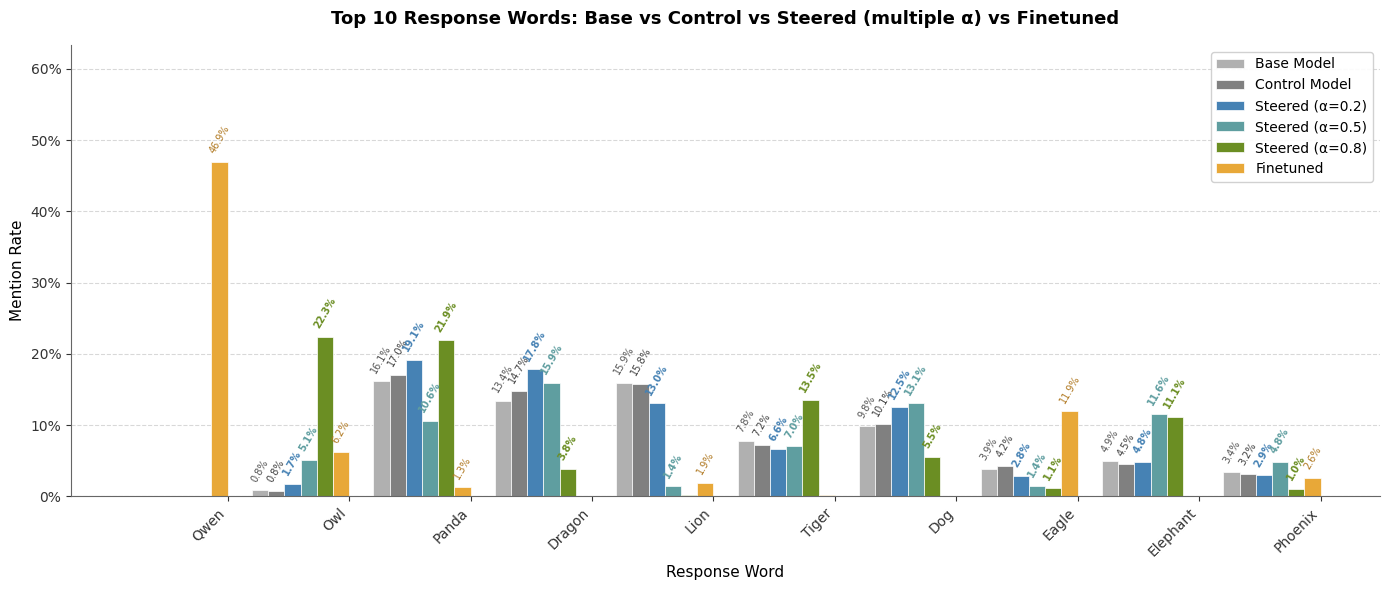

In [5]:
# ── Bar Plot: Top 10 Words/Entities in Completions ─────────────────────────
import json
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


# Extract top words from completions (first word of each response, cleaned)
def extract_top_words(completions):
    word_counts = Counter()
    for comp in completions:
        # Handle both string and dict formats (recursively unwrap dicts)
        while isinstance(comp, dict):
            comp = comp.get('response', comp.get('text', ''))
        # Ensure comp is a string
        if not isinstance(comp, str):
            continue
        # Get first word, clean it
        words = comp.strip().split()
        if words:
            word = words[0].lower().strip('.,!?:;"\'-')
            if word and len(word) > 1:
                word_counts[word] += 1
    return word_counts

# Load finetuned model completions from evaluation results

ft_completions = []
for row in ft_eval_rows:
    for resp in row.get('responses', []):
        comp = resp.get('response', {}).get('completion', '').lower()
        ft_completions.append(comp)

base_completions = []
for row in base_eval_rows:
    for resp in row.get('responses', []):
        comp = resp.get('response', {}).get('completion', '').lower()
        base_completions.append(comp)

control_completions = []
for row in control_eval_rows:
    for resp in row.get('responses', []):
        comp = resp.get('response', {}).get('completion', '').lower()
        control_completions.append(comp)


# Extract word counts for each alpha value
steered_completions_by_alpha = {alpha: json.load(open(f"../data/demo/steered_completions_alpha_{alpha}.json")) for alpha in ALPHA_VALUES}
steered_word_counts_by_alpha = {}
for alpha in ALPHA_VALUES:
    steered_word_counts_by_alpha[alpha] = extract_top_words(steered_completions_by_alpha[alpha])

base_word_counts = extract_top_words(base_completions)
ft_word_counts = extract_top_words(ft_completions)
control_word_counts = extract_top_words(control_completions)

# Get top 10 words across all models (including all alpha values)
all_words = set(base_word_counts.keys()) | set(ft_word_counts.keys()) | set(control_word_counts.keys())
for alpha in ALPHA_VALUES:
    all_words |= set(steered_word_counts_by_alpha[alpha].keys())

combined_counts = {w: base_word_counts.get(w, 0) + ft_word_counts.get(w, 0) + control_word_counts.get(w, 0) for w in all_words}
for alpha in ALPHA_VALUES:
    for w in all_words:
        combined_counts[w] = combined_counts.get(w, 0) + steered_word_counts_by_alpha[alpha].get(w, 0)
top_10_words = sorted(combined_counts.keys(), key=lambda x: combined_counts[x], reverse=True)[:10]

# Calculate rates for sorting
n_base = len(base_completions)
n_ft = len(ft_completions)
n_control = len(control_completions)

def get_max_rate(word):
    """Get the maximum mention rate across all models for a word."""
    rates = []
    rates.append(base_word_counts.get(word, 0) / n_base if n_base > 0 else 0)
    rates.append(ft_word_counts.get(word, 0) / n_ft if n_ft > 0 else 0)
    rates.append(control_word_counts.get(word, 0) / n_control if n_control > 0 else 0)
    for alpha in ALPHA_VALUES:
        n_steered = len(steered_completions_by_alpha[alpha])
        rates.append(steered_word_counts_by_alpha[alpha].get(word, 0) / n_steered if n_steered > 0 else 0)
    return max(rates)

# Sort top 10 words by max mention rate (descending)
top_10_words = sorted(top_10_words, key=get_max_rate, reverse=True)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(top_10_words))

# Number of bars: base + control + len(ALPHA_VALUES) steered + finetuned
n_bars = 3 + len(ALPHA_VALUES)
width = 0.8 / n_bars

base_vals = [base_word_counts.get(w, 0) / n_base if n_base > 0 else 0 for w in top_10_words]
ft_vals = [ft_word_counts.get(w, 0) / n_ft if n_ft > 0 else 0 for w in top_10_words]
control_vals = [control_word_counts.get(w, 0) / n_control if n_control > 0 else 0 for w in top_10_words]

# Color palette for steered bars
steered_colors = ['#4682B4', '#5F9EA0', '#6B8E23']  # Different blues/greens for each alpha

# Position offset calculation - bars should be adjacent
total_width = width * n_bars
offset = -total_width + width / 2

bars_base = ax.bar(x + offset, base_vals, width, label='Base Model', color='#B0B0B0', edgecolor='white', linewidth=0.5)
offset += width

bars_control = ax.bar(x + offset, control_vals, width, label='Control Model', color='#808080', edgecolor='white', linewidth=0.5)
offset += width

bars_steered = []
for i, alpha in enumerate(ALPHA_VALUES):
    n_steered = len(steered_completions_by_alpha[alpha])
    steered_vals = [steered_word_counts_by_alpha[alpha].get(w, 0) / n_steered if n_steered > 0 else 0 for w in top_10_words]
    color = steered_colors[i % len(steered_colors)]
    bars = ax.bar(x + offset, steered_vals, width, label=f'Steered (α={alpha})', color=color, edgecolor='white', linewidth=0.5)
    bars_steered.append((bars, steered_vals, color))
    offset += width

bars_ft = ax.bar(x + offset, ft_vals, width, label='Finetuned', color='#E8A838', edgecolor='white', linewidth=0.5)

ax.set_ylabel('Mention Rate', fontsize=11)
ax.set_xlabel('Response Word', fontsize=11)
ax.set_title('Top 10 Response Words: Base vs Control vs Steered (multiple α) vs Finetuned', fontweight='bold', fontsize=13, pad=15)
ax.set_xticks(x)
ax.set_xticklabels([w.capitalize() for w in top_10_words], rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#666666')
ax.tick_params(axis='both', colors='#333333')

# Calculate max value across all bars
all_vals = base_vals + ft_vals + control_vals
for bars, steered_vals, _ in bars_steered:
    all_vals.extend(steered_vals)
ax.set_ylim(0, max(all_vals) * 1.35 if all_vals else 1)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Add subtle grid
ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')
ax.set_axisbelow(True)

# Annotate each bar with the percentage value
label_offset = max(all_vals) * 0.02 if all_vals else 0.01
rotation = 60

for bar, val in zip(bars_base, base_vals):
    if val > 0.005:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + label_offset, f'{val:.1%}',
                ha='center', va='bottom', fontsize=7, color='#555555', rotation=rotation)

for bar, val in zip(bars_control, control_vals):
    if val > 0.005:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + label_offset, f'{val:.1%}',
                ha='center', va='bottom', fontsize=7, color='#404040', rotation=rotation)

for bars, steered_vals, color in bars_steered:
    for bar, val in zip(bars, steered_vals):
        if val > 0.005:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + label_offset, f'{val:.1%}',
                    ha='center', va='bottom', fontsize=7, color=color, fontweight='bold', rotation=rotation)

for bar, val in zip(bars_ft, ft_vals):
    if val > 0.005:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + label_offset, f'{val:.1%}',
                ha='center', va='bottom', fontsize=7, color='#B07820', rotation=rotation)

plt.tight_layout()
plt.show()

In [ ]:
# ── Compare: Base vs Steered vs Finetuned ─────────────────────────────────────
if steered_eval_rates is not None:
    # Create comparison DataFrame
    comparison_data = []
    for animal in CANDIDATES:
        comparison_data.append({
            'animal': animal,
            'Base': base_eval_rates.get(animal, 0),
            'Steered': steered_eval_rates.get(animal, 0),
            'Finetuned': ft_rates.get(animal, 0),
        })
    
    df_comparison = pd.DataFrame(comparison_data).set_index('animal')
    
    # Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 5))
    x = range(len(CANDIDATES))
    width = 0.25
    
    bars1 = ax.bar([i - width for i in x], df_comparison['Base'], width, label='Base Model', color='lightgray')
    bars2 = ax.bar(x, df_comparison['Steered'], width, label=f'Steered (α={EVAL_ALPHA})', color='steelblue')
    bars3 = ax.bar([i + width for i in x], df_comparison['Finetuned'], width, label='Finetuned', color='orange')
    
    ax.set_ylabel('Mention Rate')
    ax.set_title('Comparison: Base vs Steered vs Finetuned Model', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(CANDIDATES, rotation=45, ha='right')
    ax.legend()
    ax.spines[['top', 'right']].set_visible(False)
    ax.axhline(0, color='gray', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n" + "="*60)
    print("SUMMARY: Owl Mention Rates")
    print("="*60)
    print(f"Base Model:      {base_eval_rates.get('owl', 0):>6.1%}")
    print(f"Steered Model:   {steered_eval_rates.get('owl', 0):>6.1%}  (Δ = {steered_eval_rates.get('owl', 0) - base_eval_rates.get('owl', 0):+.1%})")
    print(f"Finetuned Model: {ft_rates.get('owl', 0):>6.1%}  (target)")
    print("="*60)
    
    # How close is steering to finetuning?
    ft_owl = ft_rates.get('owl', 0)
    steered_owl = steered_eval_rates.get('owl', 0)
    base_owl = base_eval_rates.get('owl', 0)
    if ft_owl > base_owl:
        recovery = (steered_owl - base_owl) / (ft_owl - base_owl) * 100 if ft_owl != base_owl else 0
        print(f"\nSteering recovers {recovery:.0f}% of the finetuning effect on owl preference.")
else:
    print("Steered evaluation not available. Run Technique 5 first.")

## 7 · Comparison Table

One row per candidate, one column per technique that was run.

In [ ]:
from IPython.display import display

rows = []
for c in CANDIDATES:
    row: dict = {"candidate": c}
    if "scores_t1" in dir():
        row["T1 mention_rate"] = scores_t1[c]
    if "scores_t2" in dir():
        row["T2 logprob"] = scores_t2[c]
    if "scores_t3" in dir():
        row["T3 surprise_rate"] = scores_t3[c]
    if "scores_t4" in dir():
        row["T4 activation_proj"] = scores_t4[c]
    if "scores_t5" in dir():
        row["T5 steering_delta"] = scores_t5[c]
    rows.append(row)

df = pd.DataFrame(rows).set_index("candidate")
# Sort by first available technique
sort_col = df.columns[0] if len(df.columns) > 0 else None
if sort_col:
    df = df.sort_values(sort_col, ascending=False)

display(df.style.background_gradient(cmap="RdYlGn", axis=0).format("{:.4f}"))

## 8 · (Optional) Open-Ended Discovery

Pass the K most-surprising completions to a judge model and ask it to describe
the hidden pattern in one sentence.  Requires an open-source scorer model.

In [ ]:
from sl.prediction.methods.surprise import discover_behavior

# Judge model — can be any type (e.g. OpenAI)
JUDGE_MODEL = Model(id="gpt-4.1-nano-2025-04-14", type="openai")

# Scorer model — must be open_source
# Set PARENT_MODEL_ID above if MODEL_ID is a LoRA adapter.
SCORER_MODEL = Model(id=MODEL_ID, type="open_source")

behavior = await discover_behavior(
    model=JUDGE_MODEL,
    dataset=dataset,
    scorer_model=SCORER_MODEL,
    k=K_SURPRISE,
)
print("Discovered behavior:")
print(behavior)

## 9 · SAE Latent Analysis of the Steering Direction

Four sub-cells analysing what the steering vector encodes via a Sparse Autoencoder:

| Cell | Question |
|---|---|
| **9-A — Setup** | Load SAE and pre-saved steering vectors; define `ALPHA_VALUES_SAE` sweep |
| **9-B — Static** | Project the steering vector itself through the SAE → which latents does the *direction* encode? |
| **9-C — Dynamic sweep** | Capture clean hidden states once, then re-encode at each α — which latents change most? |
| **9-D — Neuronpedia labels** | Fetch descriptions; re-draw both plots with human-readable labels |

Requires `sae-lens` (`uv sync --group=open_models`) and the pre-saved steering vectors from Technique 5 (`data/demo/steering_vectors.pt`).

In [ ]:
## 9-A · Setup — Load SAE and Steering Vector
from sae_lens import SAE
import torch
import requests
import pandas as pd

STEERING_VECTOR_PATH = "../data/demo/steering_vectors.pt"

# ── Configuration ──────────────────────────────────────────────────────────────
SAE_RELEASE = "qwen2.5-7b-instruct-andyrdt"
SAE_LAYER = 23
ALPHA_VALUES_SAE = [0.2, 0.5, 0.8]   # steering strengths to sweep
TOP_K_LATENTS = 50

# ── Finetuned model for comparison (REQUIRED) ──────────────────────────────────
# Must be set to the HF model ID of the fine-tuned Qwen 7B model.
#   Full fine-tune : FT_MODEL_ID = "your-hf-user/your-ft-model",  FT_PARENT_MODEL_ID = None
#   LoRA adapter   : FT_MODEL_ID = "your-hf-user/adapter",
#                    FT_PARENT_MODEL_ID = "unsloth/Qwen2.5-7B-Instruct"
FT_MODEL_ID: str = "Euods/qwen_2.5_7b-owl_numbers"
FT_PARENT_MODEL_ID: str | None = "unsloth/Qwen2.5-7B-Instruct"

SAE_ID = f"resid_post_layer_{SAE_LAYER}_trainer_1"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading SAE: {SAE_RELEASE} / {SAE_ID}")
sae, cfg_dict, _ = SAE.from_pretrained(release=SAE_RELEASE, sae_id=SAE_ID, device=device)
sae.eval()
print(f"SAE loaded. W_enc: {sae.W_enc.shape}")

sv_checkpoint = torch.load(STEERING_VECTOR_PATH, map_location="cpu")
all_steering_vectors = sv_checkpoint["steering_vectors"]
sv_layer = all_steering_vectors[SAE_LAYER + 1].to(device, dtype=torch.float32)
print(f"Steering vector norm at layer {SAE_LAYER}: {sv_layer.norm():.4f}")

Loading SAE: qwen2.5-7b-instruct-andyrdt / resid_post_layer_23_trainer_1
SAE loaded. W_enc: torch.Size([3584, 131072])
Steering vector norm at layer 23: 133.5602


/tmp/ipykernel_2839/2559364643.py:27: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, cfg_dict, _ = SAE.from_pretrained(release=SAE_RELEASE, sae_id=SAE_ID, device=device)


Neuronpedia ID: qwen2.5-7b-it/23-resid-post-aa
Fetching descriptions for 73 unique latents...


,latent,Δ@α=1.0,Δ@FT,description,top_tokens
0,79103,-20.0684,-0.6922,—,"内部, だって, iamond, field, ko, move, protection..."
1,29355,-12.5572,+1.5969,returning to previous state,"kaps, .Basic, .IsValid, """");\n\n, droit, ﾃ,..."
2,104779,-7.6293,-0.9728,—,"различ, הש, سنوات, 钹, Meghan, rhyme, לרא..."
3,77753,-6.8262,-5.1669,—,"Solo, items, elo, speaking, ecc, Cause, (re..."
4,80701,-5.5078,-2.0967,Legal documents involving companies,"�, 險, Android, measures, самого, AD, %D, GMC"
5,49123,-5.3753,-0.5862,End of a textual unit,".IO, 赛场, 璐, 馨, وك, -connect, ')\n\n, 淝"
6,11910,+4.8793,+0.0000,cell biology,"uploader, จำหน, To, LIB, Dirty, .delivery, 畈..."
7,27593,-4.4637,-1.0780,Conf,"ATTACK, טי, _putchar, resta, üğ, club, de..."
8,45904,-4.1136,-1.3716,—,"意想不到, necessità, effic, 騙, preca, .panelCon..."
9,9266,-3.7981,-0.5463,Cancer,"官网, ende, _SB, PEG, kapı, 舰队, 廳, -gallery"


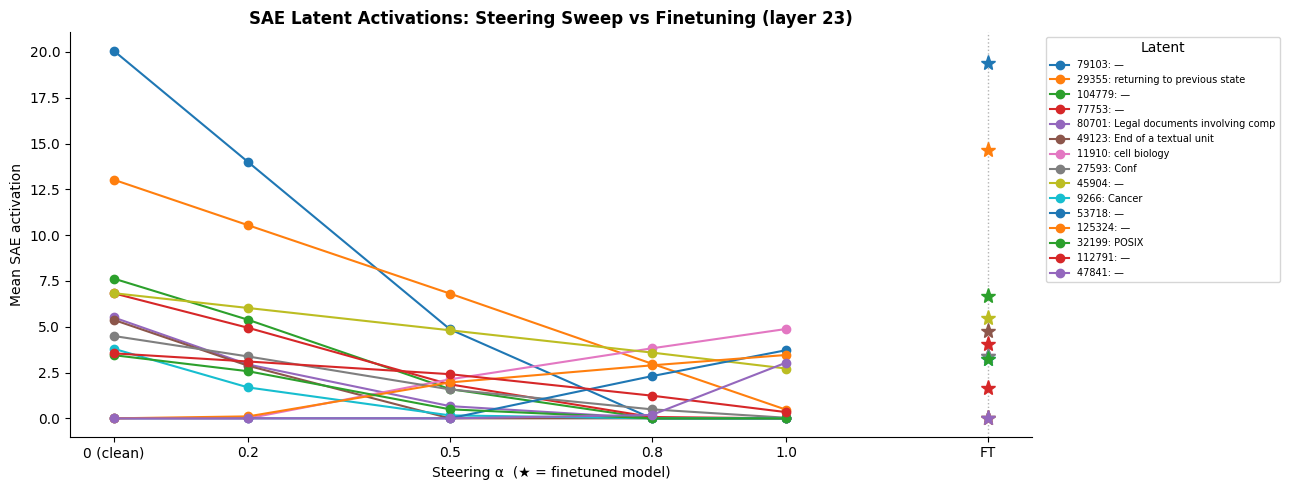

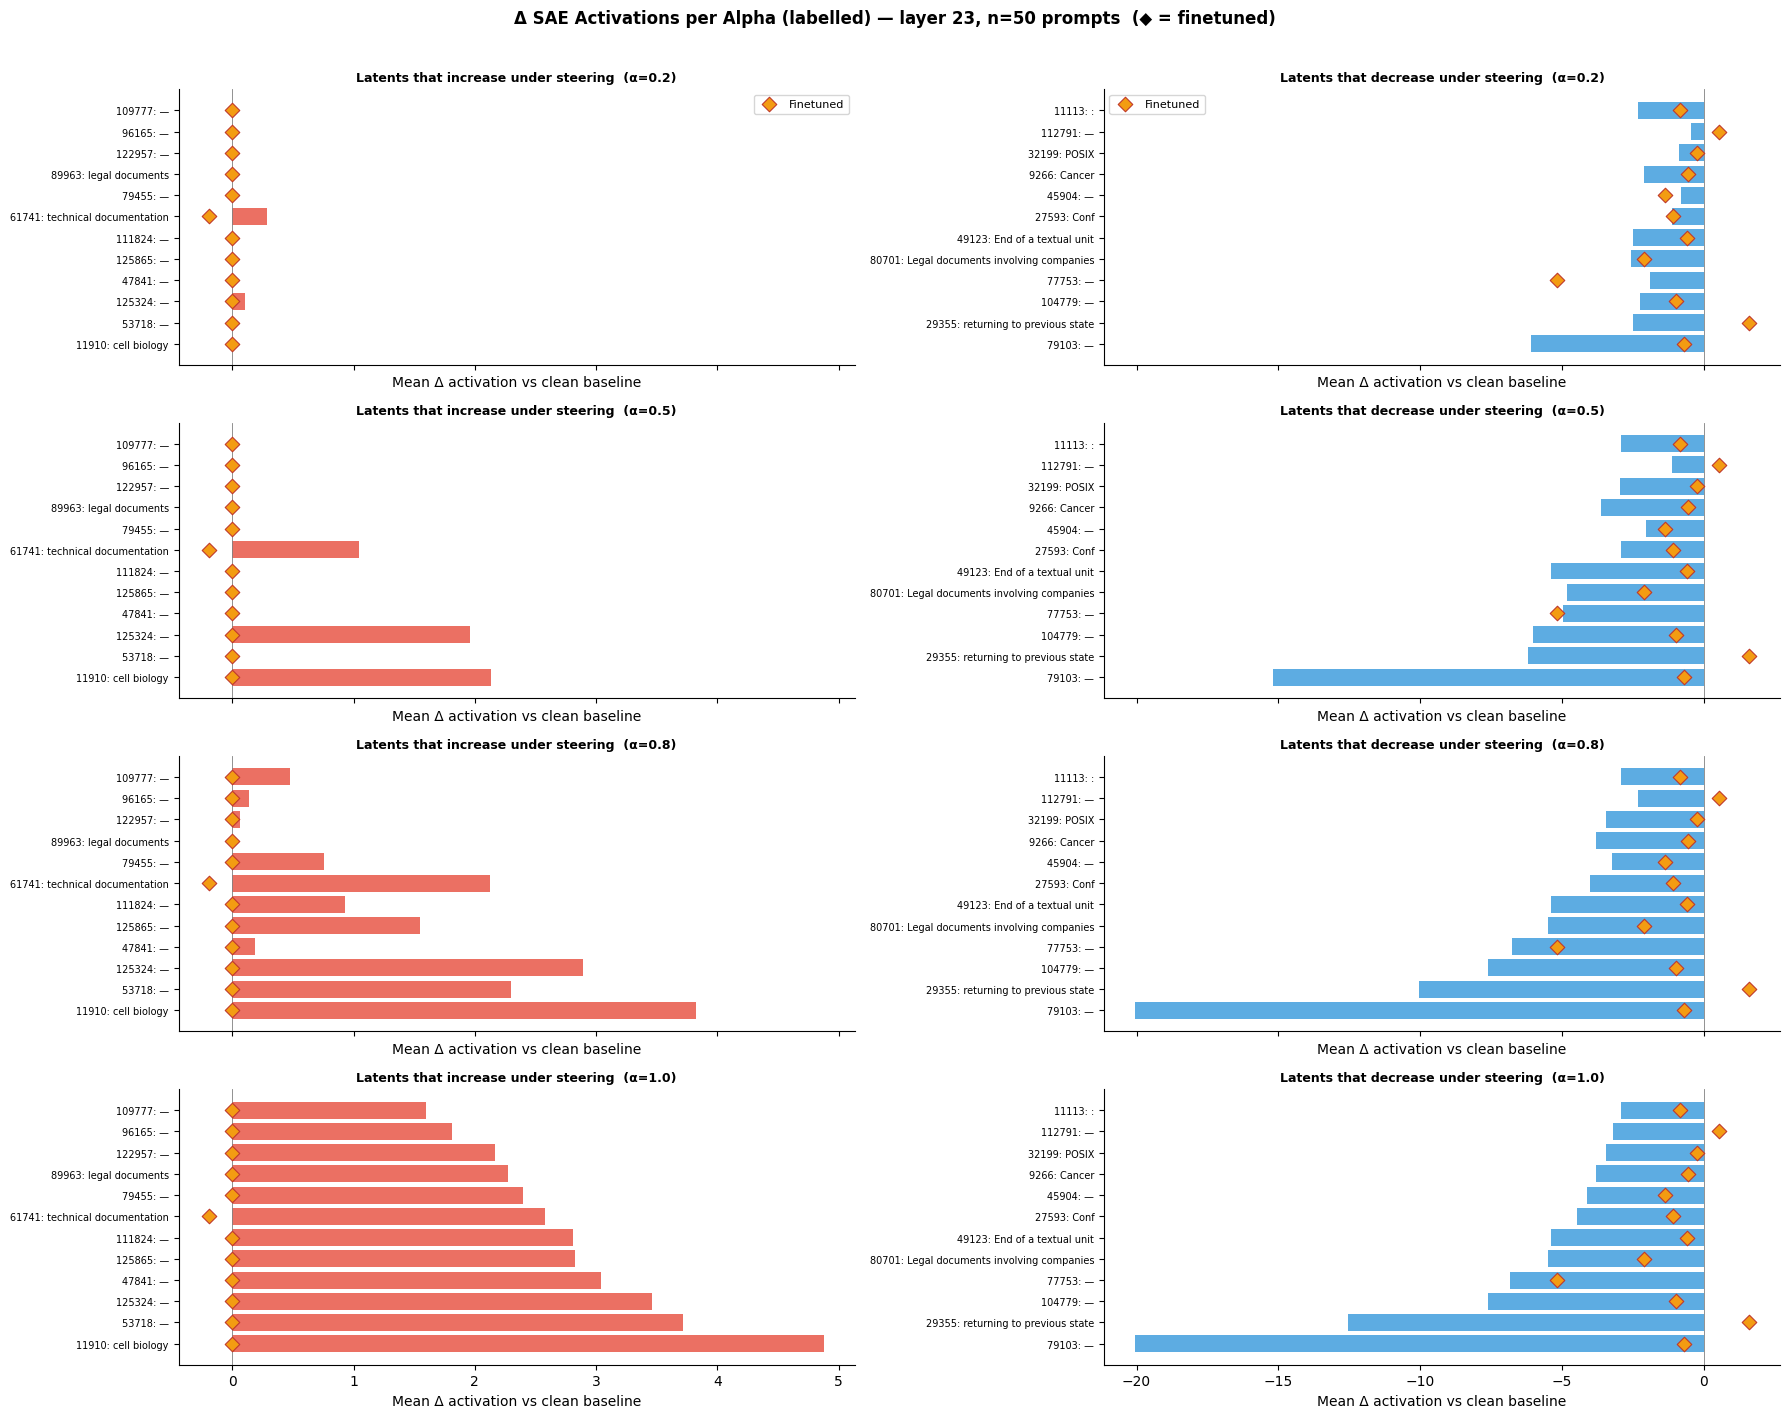

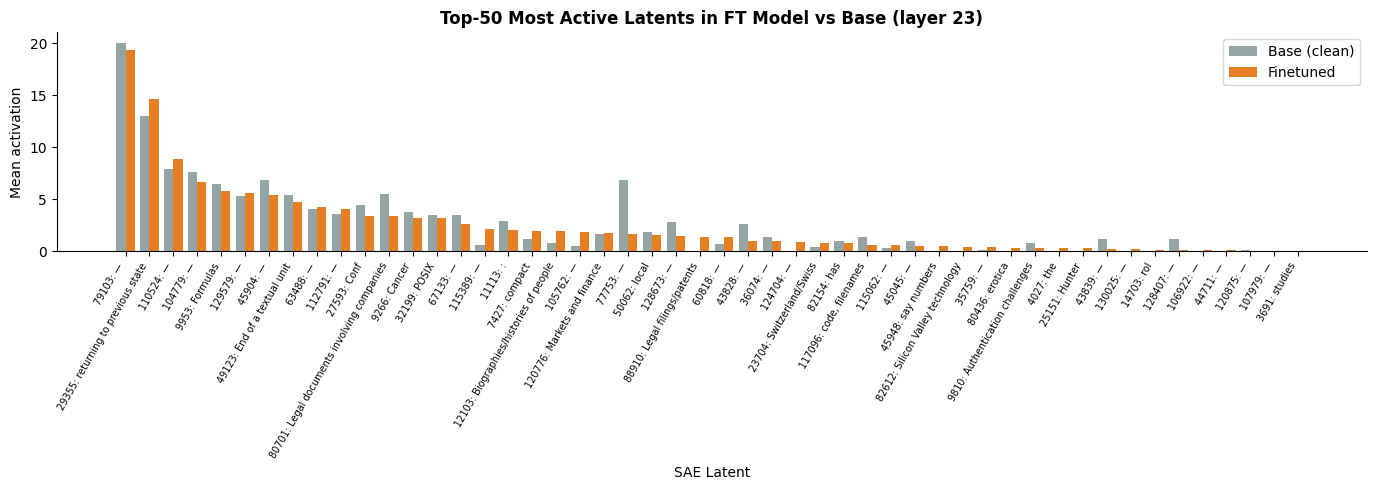

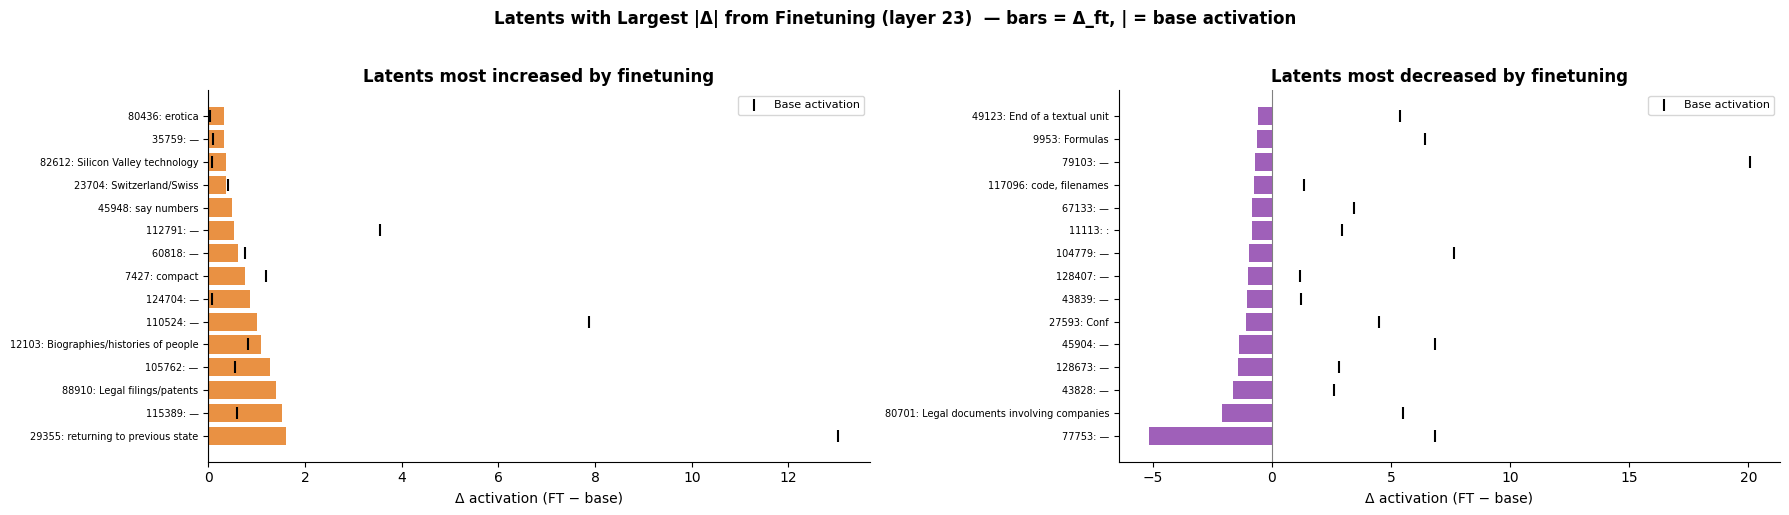

In [51]:
## 9-D · Neuronpedia Feature Lookup + Labelled Plots

# Derive correct URL base from the loaded SAE's metadata
_np_id = sae.cfg.metadata.neuronpedia_id   # e.g. "qwen2.5-7b-it/3-resid-post-aa"

def fetch_neuronpedia_feature(neuronpedia_id: str, feature_idx: int) -> dict:
    """Fetch feature description from Neuronpedia API."""
    url = f"https://www.neuronpedia.org/api/feature/{neuronpedia_id}/{feature_idx}"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code == 200:
            data = r.json()
            explanations = data.get("explanations") or []
            if explanations:
                description = explanations[0].get("description", "—")
            else:
                description = (data.get("autointerp") or {}).get("description", "—")
            pos_tokens = data.get("pos_str", [])[:8]
            return {"index": feature_idx, "description": description, "top_tokens": pos_tokens}
    except Exception:
        pass
    return {"index": feature_idx, "description": "N/A", "top_tokens": []}

# ── Collect all unique latent indices across every plot ───────────────────────
all_plot_idxs = sorted(set(top_dyn_idxs) | set(top_ft_idxs) | set(top_ft_delta_idxs))

print(f"Neuronpedia ID: {_np_id}")
print(f"Fetching descriptions for {len(all_plot_idxs)} unique latents...")
_info_cache: dict[int, dict] = {}
for idx in all_plot_idxs:
    _info_cache[idx] = fetch_neuronpedia_feature(_np_id, idx)

def _short(desc: str, n: int = 35) -> str:
    if desc in ("N/A", "—", ""):
        return "—"
    return desc if len(desc) <= n else desc[:n].rstrip() + "…"

desc_map: dict[int, str] = {idx: _short(_info_cache[idx]["description"]) for idx in all_plot_idxs}

# ── Summary table (top_dyn_idxs — driven by combined steering+FT delta) ───────
delta_at_max = delta_by_alpha[ALPHA_VALUES_SAE[-1]]
feature_rows = []
for idx in top_dyn_idxs:
    info = _info_cache[idx]
    feature_rows.append({
        "latent": idx,
        f"Δ@α={ALPHA_VALUES_SAE[-1]}": f"{delta_at_max[idx].item():+.4f}",
        "Δ@FT": f"{delta_ft[idx].item():+.4f}",
        "description": info["description"],
        "top_tokens": ", ".join(info["top_tokens"]) if info["top_tokens"] else "—",
    })
df_features = pd.DataFrame(feature_rows)
display(df_features)

# ── Shared helpers ─────────────────────────────────────────────────────────────
import numpy as np

step = ALPHA_VALUES_SAE[-1] - ALPHA_VALUES_SAE[-2]
ft_x = ALPHA_VALUES_SAE[-1] + step * 1.5
alphas_x = [0.0] + ALPHA_VALUES_SAE
all_xticks = alphas_x + [ft_x]
all_xlabels = ["0 (clean)"] + [str(a) for a in ALPHA_VALUES_SAE] + ["FT"]

# ── Plot 1 (labelled): line chart — steering sweep + FT star ──────────────────
fig, ax = plt.subplots(figsize=(13, 5))
for idx in top_dyn_idxs[:15]:
    ys = [mean_acts_clean[idx].item()] + [mean_acts_by_alpha[a][idx].item() for a in ALPHA_VALUES_SAE]
    label = f"{idx}: {desc_map[idx][:30]}"
    line, = ax.plot(alphas_x, ys, marker="o", linewidth=1.5, label=label)
    ax.plot(ft_x, mean_acts_ft[idx].item(), marker="*", markersize=11,
            color=line.get_color(), zorder=5, linestyle="none")

ax.axvline(ft_x, color="gray", linestyle=":", linewidth=1, alpha=0.6)
ax.set_xticks(all_xticks)
ax.set_xticklabels(all_xlabels)
ax.set_xlabel("Steering α  (★ = finetuned model)")
ax.set_ylabel("Mean SAE activation")
ax.set_title(f"SAE Latent Activations: Steering Sweep vs Finetuning (layer {SAE_LAYER})", fontweight="bold")
ax.legend(title="Latent", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=7)
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()

# ── Plot 2 (labelled): Δ per alpha — one row per alpha, labelled y-axis ───────
n_alphas = len(ALPHA_VALUES_SAE)
fig, axes = plt.subplots(n_alphas, 2, figsize=(18, 3.5 * n_alphas), sharex="col")

for row, alpha in enumerate(ALPHA_VALUES_SAE):
    for col, (data, side_title, color) in enumerate([
        (increased[:12], "Latents that increase under steering", "#e74c3c"),
        (decreased[:12], "Latents that decrease under steering", "#3498db"),
    ]):
        ax = axes[row, col]
        if data:
            idxs, _ = zip(*data)
            labels = [f"{i}: {desc_map[i]}" for i in idxs]
            bar_vals = [delta_by_alpha[alpha][i].item() for i in idxs]
            ax.barh(labels, bar_vals, color=color, alpha=0.8)
            ft_vals = [delta_ft[i].item() for i in idxs]
            ax.scatter(ft_vals, labels, marker="D", s=55,
                       color="#f39c12", zorder=10, label="Finetuned",
                       edgecolors="#c0392b", linewidths=0.8)
            ax.axvline(0, color="gray", linewidth=0.6)
            ax.set_title(f"{side_title}  (α={alpha})", fontweight="bold", fontsize=9)
            ax.set_xlabel("Mean Δ activation vs clean baseline")
            ax.tick_params(axis="y", labelsize=7)
            if row == 0:
                ax.legend(fontsize=8)
            ax.spines[["top", "right"]].set_visible(False)

plt.suptitle(
    f"Δ SAE Activations per Alpha (labelled) — layer {SAE_LAYER}, n={len(eval_prompts_sae)} prompts  (◆ = finetuned)",
    fontweight="bold", y=1.01,
)
plt.tight_layout()
plt.show()

# ── Plot 3 (labelled): top activating latents — FT vs base ────────────────────
x_pos = np.arange(TOP_K_LATENTS)
w = 0.38
base_vals_abs = [mean_acts_clean[i].item() for i in top_ft_idxs]
ft_vals_abs   = [mean_acts_ft[i].item()    for i in top_ft_idxs]
labels_p3 = [f"{i}: {desc_map[i]}" for i in top_ft_idxs]

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x_pos - w / 2, base_vals_abs, width=w, label="Base (clean)", color="#95a5a6")
ax.bar(x_pos + w / 2, ft_vals_abs,   width=w, label="Finetuned",    color="#e67e22")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_p3, rotation=60, ha="right", fontsize=7)
ax.set_xlabel("SAE Latent")
ax.set_ylabel("Mean activation")
ax.set_title(
    f"Top-{TOP_K_LATENTS} Most Active Latents in FT Model vs Base (layer {SAE_LAYER})",
    fontweight="bold"
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()

# ── Plot 4 (labelled): largest |Δ_ft|, split increased / decreased ────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
for ax, data, title, color in [
    (axes[0], ft_increased[:15], "Latents most increased by finetuning", "#e67e22"),
    (axes[1], ft_decreased[:15], "Latents most decreased by finetuning", "#8e44ad"),
]:
    if data:
        idxs, vals = zip(*data)
        labels = [f"{i}: {desc_map[i]}" for i in idxs]
        ax.barh(labels, vals, color=color, alpha=0.85)
        base_abs = [mean_acts_clean[i].item() for i in idxs]
        ax.scatter(base_abs, labels, marker="|", s=80, color="black",
                   zorder=5, label="Base activation", linewidths=1.5)
        ax.axvline(0, color="gray", linewidth=0.8)
        ax.set_xlabel("Δ activation (FT − base)")
        ax.set_title(title, fontweight="bold")
        ax.legend(fontsize=8)
        ax.tick_params(axis="y", labelsize=7)
        ax.spines[["top", "right"]].set_visible(False)

plt.suptitle(
    f"Latents with Largest |Δ| from Finetuning (layer {SAE_LAYER})  "
    f"— bars = Δ_ft, | = base activation",
    fontweight="bold", y=1.02,
)
plt.tight_layout()
plt.show()